In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys

sys.path.insert(0, "/Users/tommylees/github/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Download data from [zenodo](https://zenodo.org/record/5600851#.YfF5f_XP3zA)
- train_cell_states.nc
- test_cell_states.nc

In [2]:
data_dir = Path("/Users/tommylees/Downloads")
train_cn = xr.open_dataset(data_dir / "train_cell_states.nc")
test_cn = xr.open_dataset(data_dir / "test_cell_states.nc")
cn = xr.concat([train_cn, test_cn], dim="date")

In [3]:
# get the test obs data too
ds = xr.open_dataset(data_dir / "extended_camels_data.nc")
ds = ds.sel(
    time=test_cn.date.values, 
    station_id=np.isin(ds.station_id.values, 
    test_cn.station_id.values.astype(int))
)

# Run PCA over the 64 Dimensions

Let 𝐗raw be the 𝑛×𝑝 data matrix with 𝑛 rows (data points) and 𝑝 columns (variables, or features). After subtracting the mean vector 𝝁 from each row, we get the centered data matrix 𝐗. Let 𝐕 be the 𝑝×𝑘 matrix of some 𝑘 eigenvectors that we want to use; these would most often be the 𝑘 eigenvectors with the largest eigenvalues. Then the 𝑛×𝑘 matrix of PCA projections ("scores") will be simply given by  𝐙=𝐗𝐕 
[SO Answer](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)

- [PCA Lecture Notes](http://strata.uga.edu/8370/lecturenotes/principalComponents.html#:~:text=Positive%20loadings%20indicate%20a%20variable,effect%20on%20that%20principal%20component.)
-[Raschka Version](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)
- [SO The Maths](https://stats.stackexchange.com/q/32174/213097)

In [4]:
# standardize the vector (zero mean, unit variance)
X = test_cn["c_n"].dropna(dim="date", how="all").values
X = X.reshape(-1, X.shape[-1])
X.shape

(2688042, 64)

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [145]:
N_COMPONENTS = 5

In [146]:
# standardize the vector (zero mean, unit variance)
scaler = StandardScaler()
pca = PCA(n_components=None)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca)])

In [147]:
Xhat = pipe.fit_transform(X)

In [275]:
Xhat.shape
eigenvectors = pipe["pca"].components_

In [149]:
df = pd.DataFrame(
    data=Xhat, 
    columns=[f"pc{i}" for i in np.arange(Xhat.shape[-1])]
)
df.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc54,pc55,pc56,pc57,pc58,pc59,pc60,pc61,pc62,pc63
0,3.262628,0.728790,0.126065,-0.562274,-1.027894,-0.873909,-0.364519,-0.337231,-0.494254,-0.441951,...,-0.007024,0.160403,0.088153,0.346183,-0.617588,0.782683,0.064369,-0.501886,-0.057365,-0.022647
1,4.957962,1.521306,-0.057953,0.368113,-1.512446,-1.503614,0.164880,-0.252592,-0.180377,-0.471512,...,-0.456772,-0.022579,-0.130587,0.125402,-0.424944,0.202308,-0.027606,0.189670,-0.070903,-0.050349
2,1.420332,-1.988545,0.318983,-0.829202,-1.259229,1.023188,-1.592781,-0.668479,-0.516075,1.012436,...,0.019853,0.017331,0.091851,0.413799,-0.333861,0.507507,-0.107720,-0.332543,0.119389,-0.072690
3,2.879316,2.271678,0.338327,1.112965,0.743659,-2.681448,-0.682524,-1.640078,0.308905,1.589887,...,0.295793,-0.400718,-0.439070,0.081399,-0.144270,0.351448,0.059124,-0.172732,0.028621,0.156909
4,2.171415,1.224802,0.447295,0.020904,0.039604,-2.330711,0.094147,-1.431649,0.432644,1.062917,...,0.413903,-0.054225,-0.409962,0.024709,-0.122900,0.307746,-0.072527,-0.211164,-0.036913,0.087174


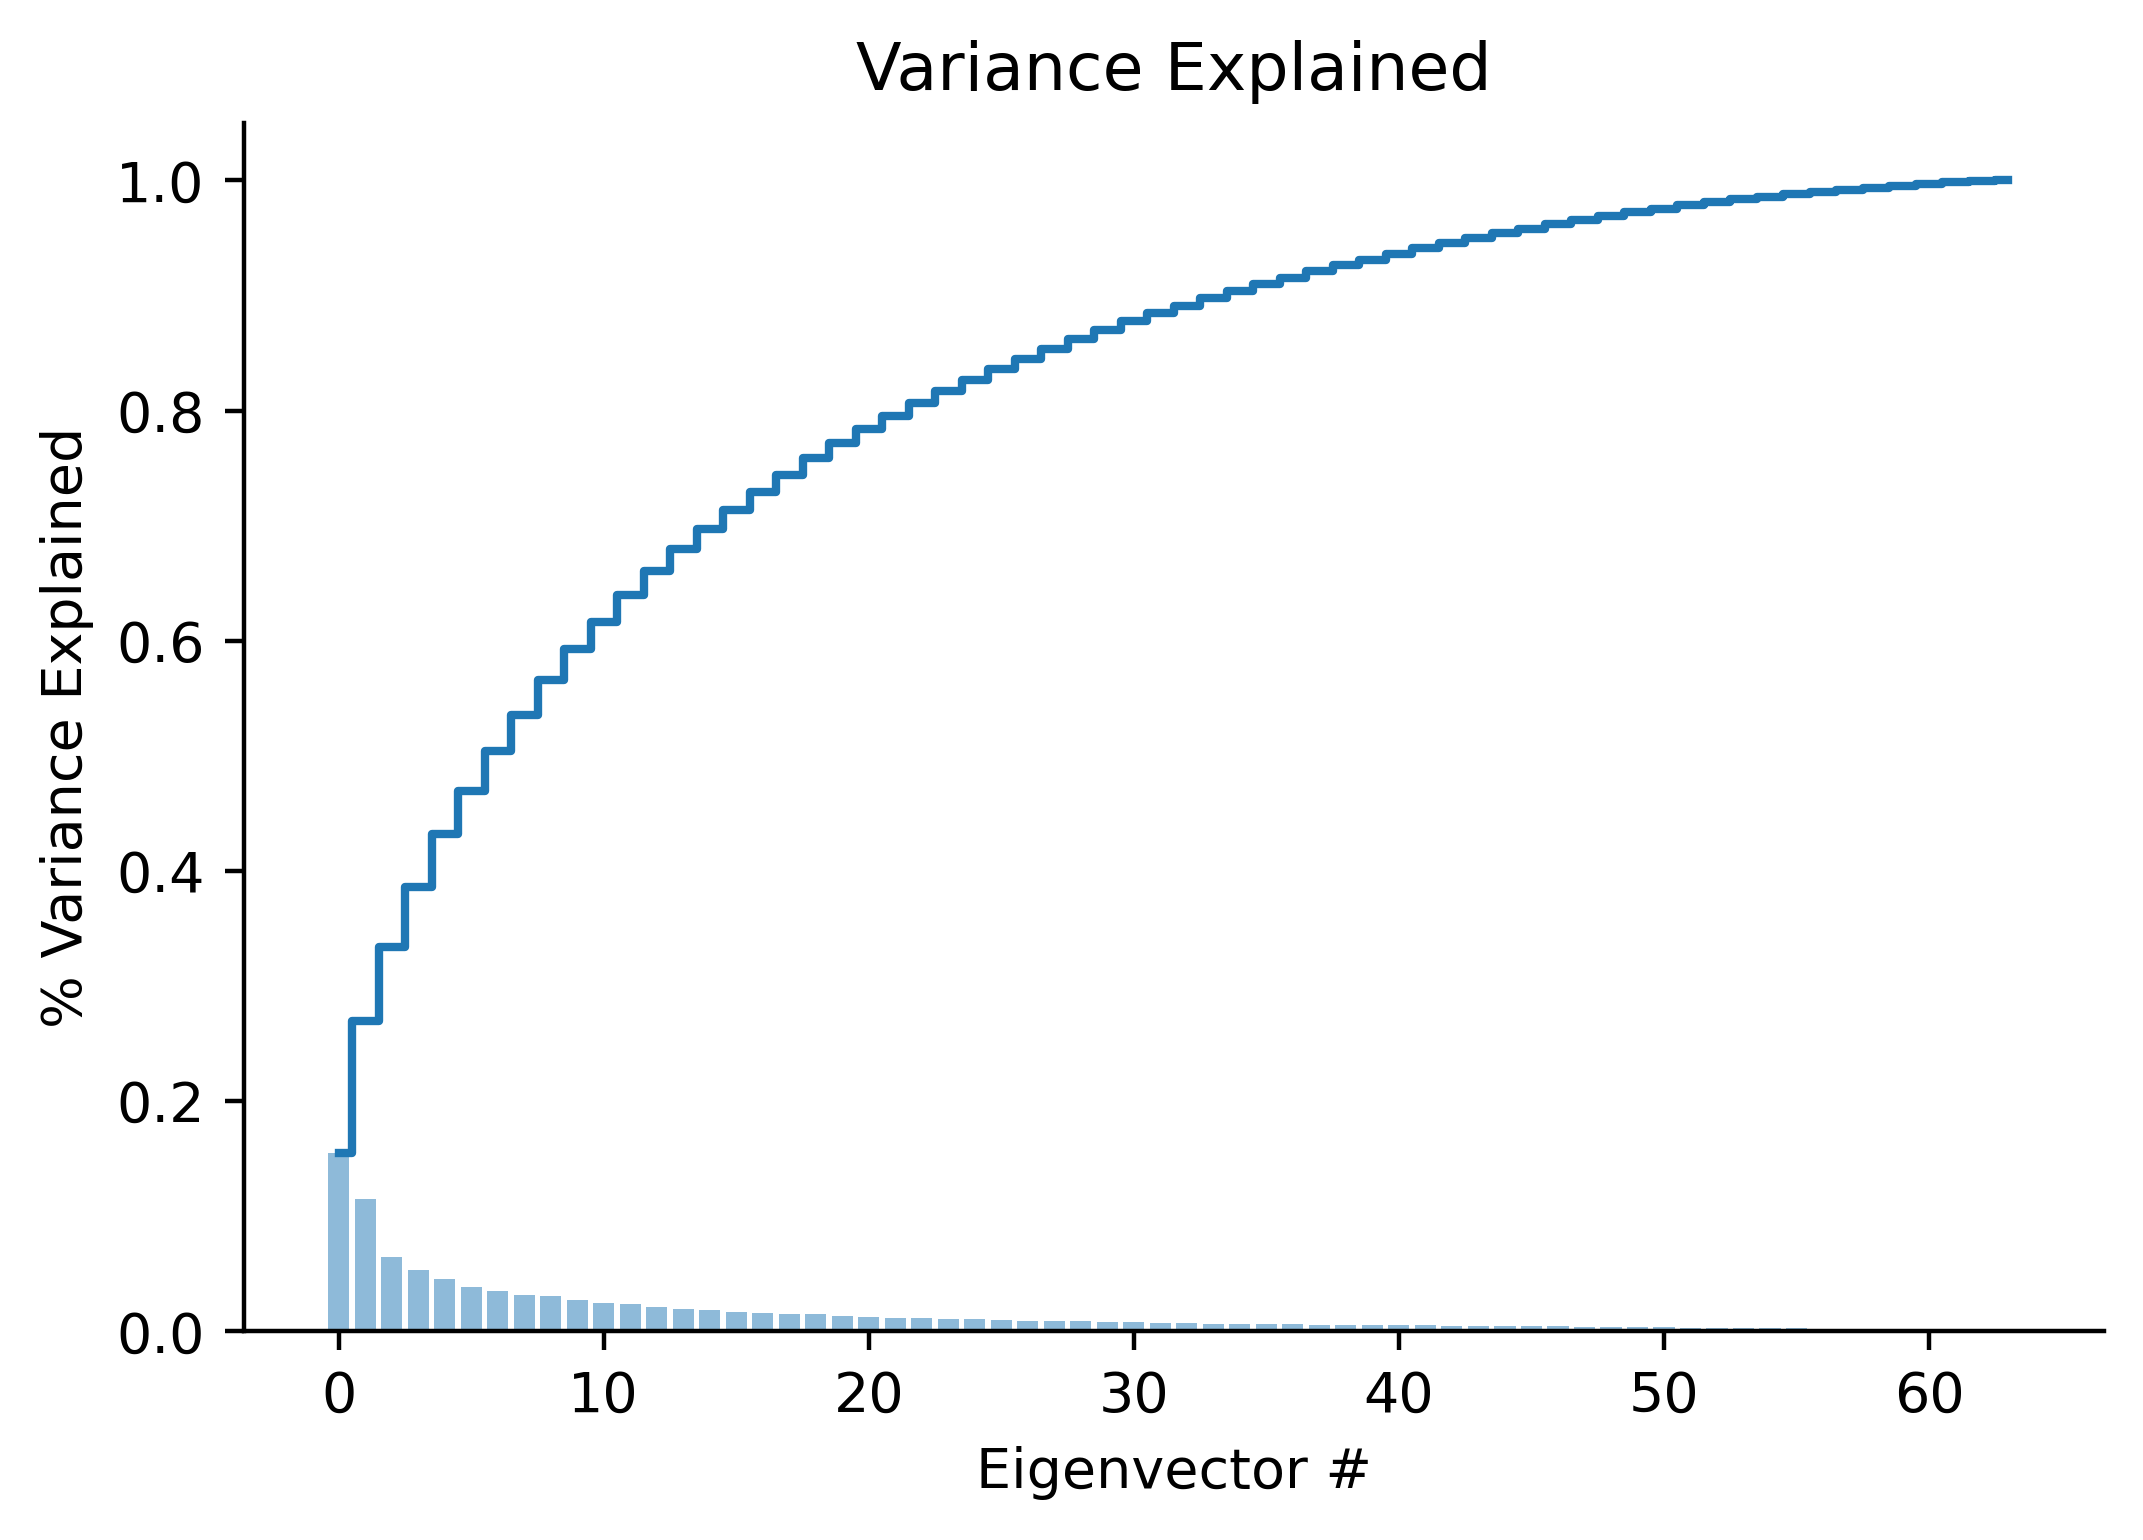

In [150]:
# Scree plot
var_exp_ = pipe["pca"].explained_variance_ratio_
cum_var_exp_ = np.cumsum(var_exp_)

with plt.rc_context({"figure.dpi": 400}):
    plt.bar(range(var_exp_.shape[0]), var_exp_, alpha = 0.5, 
            align = 'center', label = 'individual explained variance')
    plt.step(range(var_exp_.shape[0]), cum_var_exp_, 
             where = 'mid', label = 'cumulative explained variance')

    ax = plt.gca()
    ax.set_title("Variance Explained")
    ax.set_xlabel("Eigenvector #")
    ax.set_ylabel("% Variance Explained")
    sns.despine()

In [151]:
dd = pd.DataFrame({"pc": np.arange(var_exp_.shape[0]), "explained_variance": var_exp_})
dd["cumulative"] = dd["explained_variance"].cumsum()
# dd.loc[dd["cumulative"] > 0.8]

In [152]:
pca = pipe["pca"]
print(dir(pca))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_n_features', '_fit', '_fit_full', '_fit_svd_solver', '_fit_truncated', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'components_', 'copy', 'explained_variance_', 'explained_variance_ratio_', 'fit', 'fit_transform', 'get_covariance', 'get_params', 'get_precision', 'inverse_transform', 'iterated_power', 'mean_', 'n_components', 'n_components_', 'n_features_', 'n_features_in_', 'n_samples_', 'noise_variance_', 'random_state', 'score', 'score_samples', 'set_params', 'singular_values_', 'svd_solver', 't

In [160]:
N_COMPONENTS = 6

In [184]:
for n_pc in np.arange():
    E = pca.components_[:n_pc, :]
    prediction = np.einsum("kp,nk->np", E, Xhat[:, :n_pc])

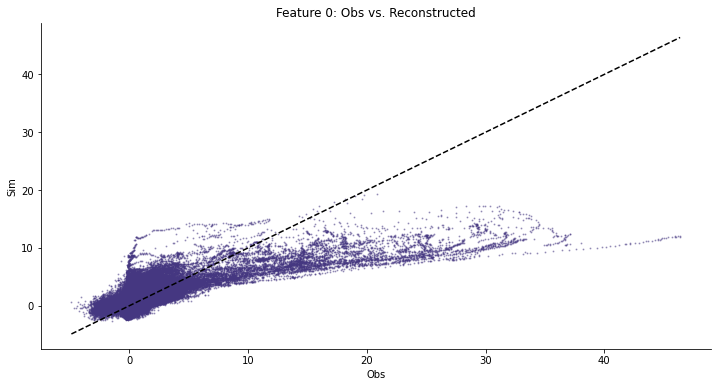

In [185]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

f, ax = plt.subplots(figsize=(12, 6))


n_unique_vals = 64
colors = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))
# for feature in tqdm(np.arange(n_unique_vals)):

feature = 0
obs = X[:, feature]
sim = prediction[:, feature]
ax.scatter(obs, sim, alpha=0.4, s=1, color=colors[n_pc])

lim = (min([np.nanmin(obs), np.nanmin(sim)]), max([np.nanmax(obs), np.nanmax(sim)]))
ax.plot(lim, lim, ls="--", color="k")
ax.set_xlabel("Obs")
ax.set_ylabel("Sim")
ax.set_title(f"Feature {feature}: Obs vs. Reconstructed")
sns.despine();

In [216]:
ds.isel(station_id=0)

<xarray.Dataset>
Dimensions:         (time: 4018)
Coordinates:
    station_id      int64 10002
  * time            (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
    spatial_ref     int64 0
Data variables: (12/15)
    precipitation   (time) float64 ...
    pet             (time) float64 ...
    temperature     (time) float64 ...
    discharge_spec  (time) float64 ...
    discharge_vol   (time) float64 ...
    peti            (time) float64 ...
    ...              ...
    windspeed       (time) float64 ...
    swvl1           (time) float32 0.3428 0.3465 0.3532 ... 0.2976 0.2957 0.2939
    swvl2           (time) float32 ...
    swvl3           (time) float32 ...
    swvl4           (time) float32 ...
    sd              (time) float32 ...

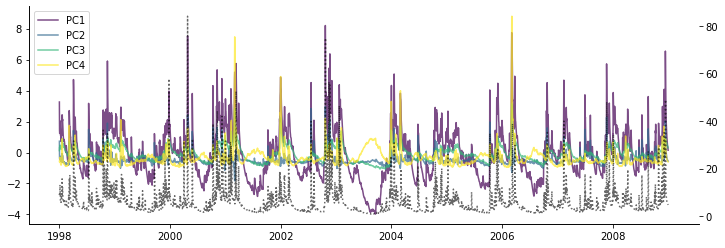

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

f, ax = plt.subplots(figsize=(12, 4))

n_pcs = 4
n_unique_vals = n_pcs
colors = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))

ax2 = ax.twinx()
ax2.plot(ds["time"], ds.isel(station_id=0)["discharge_vol"].values, linestyle=":", color="k", alpha=0.6)
for ix in np.arange(n_pcs):
    y = df[f"pc{ix}"].values.reshape(4018, 669)[:, 0]
    x = test_cn["date"].values
    ax.plot(x, y, label=f"PC{ix + 1}", color=colors[ix], alpha=0.7)

ax.legend()
sns.despine()

In [189]:
def convert_to_xarray(df: pd.DataFrame) -> xr.Dataset:
    times = test_cn.date.values
    station_ids = test_cn.station_id.values

    all_ds = []
    for c in df.columns:
        vals = df[c].values.reshape(4018, 669)
        dd = xr.Dataset(
            {c: (("time", "station_id"), vals)},
            coords={"station_id": station_ids, "time": times}
        )
        all_ds.append(dd)

    return xr.merge(all_ds)

pc_ds = convert_to_xarray(df)
pc_ds = pc_ds.sel(station_id=np.isin(pc_ds.station_id.astype(int), ds.station_id))

In [ ]:
import numpy.ma as ma

def calculate_all_pc_variables_correlations():
    

In [215]:
import numpy.ma as ma

variables = []
pcs = []
correlations = []

variable = "swvl1"

data_vars = ds.data_vars 
data_vars = ["precipitation", "temperature", "swvl1", "swvl2", "swvl3", "swvl4", "sd"]

for variable in data_vars:
    pbar = tqdm(np.arange(64), desc=f"{variable}")
    for pc in pbar:
        a = ma.masked_invalid(pc_ds[f"pc{pc}"].transpose("time", "station_id"))
        b = ma.masked_invalid(ds[variable].transpose("time", "station_id"))
        mask = (~a.mask & ~b.mask)

        c = ma.corrcoef(a[mask], b[mask])[0, 1]

        variables.append(variable)
        pcs.append(pc)
        correlations.append(c)

sd: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.13it/s]


In [273]:
corr_df = pd.DataFrame({
    "variable": variables,
    "pc": pcs,
    "correlation": correlations
})

corr_long_df = corr_df.set_index(["pc"]).pivot(columns="variable")
corr_long_df.columns = corr_long_df.columns.droplevel()
corr_ds = corr_long_df.to_xarray()
corr_ds.to_netcdf("/Users/tommylees/Downloads/PCA_correlations.nc")

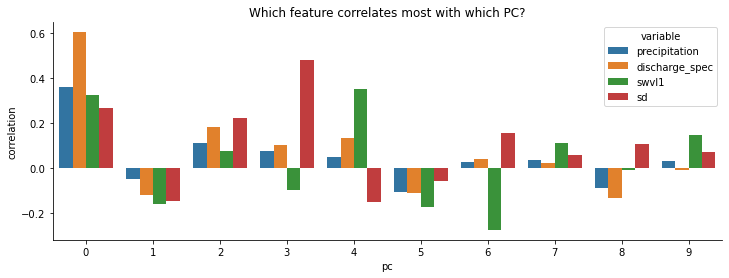

In [250]:
data = corr_df.loc[np.isin(corr_df["variable"], ["discharge_spec", "swvl1", "sd", "precipitation"])]
data = data.loc[data["pc"] < 10]
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x="pc", y="correlation", hue="variable", data=data)
ax.set_title("Which feature correlates most with which PC?")
sns.despine()

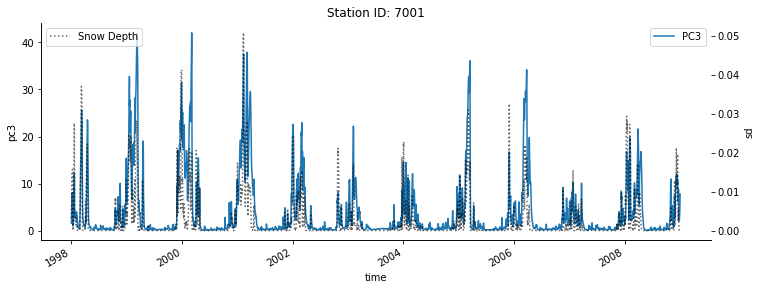

In [299]:
f, ax = plt.subplots(figsize=(12, 4))

station_id = 7001
pc_ds["pc3"].sel(station_id=str(station_id)).plot(ax=ax, label="PC3")

ax2 = ax.twinx()
ds["sd"].sel(station_id=station_id).plot(ax=ax2, label="Snow Depth", color="k", alpha=0.6, ls=":")
ax.legend()
ax2.legend(loc="upper left")

ax2.set_title("")
ax.set_title(f"Station ID: {station_id}")
sns.despine()

In [296]:
print(eigenvectors.shape)
assert np.allclose(np.linalg.norm(eigenvectors, axis=1), 1)
# assert np.allclose(np.linalg.norm(eigenvectors, axis=0), 1)

(64, 64)


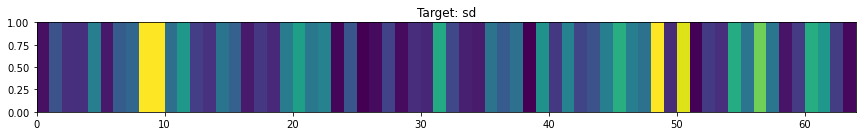

In [298]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = 1
target_var = "sd"
f, ax = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))
w = eigenvectors[3, :]
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
ax.set_title(f"Target: {target_var}")
plt.tight_layout()

In [187]:
ds[["precipitation", "temperature", "swvl1", "swvl2", "swvl3", "swvl4", "sd"]]

<xarray.Dataset>
Dimensions:        (time: 4018, station_id: 668)
Coordinates:
  * station_id     (station_id) int64 10002 10003 1001 ... 96002 96004 97002
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
    spatial_ref    int64 ...
Data variables:
    precipitation  (time, station_id) float64 ...
    temperature    (time, station_id) float64 ...
    swvl1          (station_id, time) float32 ...
    swvl2          (station_id, time) float32 ...
    swvl3          (station_id, time) float32 ...
    swvl4          (station_id, time) float32 ...
    sd             (station_id, time) float32 ...

In [174]:
from tqdm import tqdm

def calculate_error_of_reproduced_X(pca: PCA, Xhat: np.ndarray, X: np.ndarray, n_components: int) -> float:
    E = pca.components_[:n_components, :]
    prediction = np.einsum("kp,nk->np", E, Xhat[:, :n_components])

    # reproduced error
    err = np.sqrt((np.abs(X - prediction))**2).mean()
    return err


def calculate_errors_of_reproduced_X(pca: PCA, Xhat: np.ndarray, X: np.ndarray):
    total_components = X.shape[-1]
    errors = []
    for n_c in tqdm(np.arange(total_components)):
        err = calculate_error_of_reproduced_X(pca, Xhat, X, n_c)
        errors.append(err)

    err = pd.DataFrame({"pc": np.arange(total_components), "rmse": errors})
    return err


if False:
    err = calculate_errors_of_reproduced_X(pca, Xhat, X)

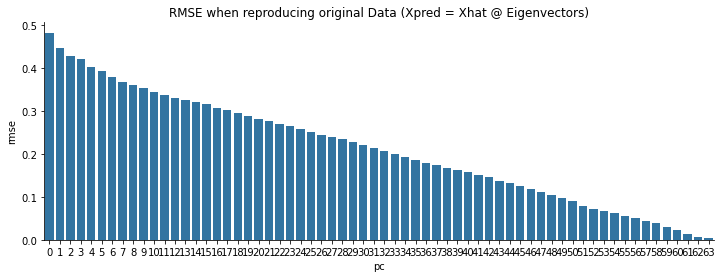

In [186]:
if "err" in globals().keys():
    f, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x="pc", y="rmse", data=err, color="C0")
    ax.set_title("RMSE when reproducing original Data (Xpred = Xhat @ Eigenvectors)")
    sns.despine()

# Play with PCA
- https://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python

In [83]:
# https://stackoverflow.com/a/27933271/9940782
from numpy import array, dot, mean, std, empty, argsort
from numpy.linalg import eigh, solve
from numpy.random import randn
from matplotlib.pyplot import subplots, show

def cov(X):
    """
    Covariance matrix
    note: specifically for mean-centered data
    note: numpy's `cov` uses N-1 as normalization
    """
    return dot(X.T, X) / X.shape[0]
    # N = data.shape[1]
    # C = empty((N, N))
    # for j in range(N):
    #   C[j, j] = mean(data[:, j] * data[:, j])
    #   for k in range(j + 1, N):
    #       C[j, k] = C[k, j] = mean(data[:, j] * data[:, k])
    # return C


def pca(data, pc_count = None):
    """
    Principal component analysis using eigenvalues
    note: this mean-centers and auto-scales the data (in-place)
    """
    data -= mean(data, 0)
    data /= std(data, 0)
    C = cov(data)
    E, V = eigh(C)
    key = argsort(E)[::-1][:pc_count]
    E, V = E[key], V[:, key]
    U = dot(data, V)  # used to be dot(V.T, data.T).T
    return U, E, V

In [64]:
Xhat, evals, evecs = pca(X, 2)

In [76]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pca = PCA(n_components=2)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca)])

In [78]:
Xhat2 = pipe.fit_transform(X)

In [81]:
Xhat

array([[ 1.19995037,  0.43881357],
       [ 1.84159694, -0.4127559 ],
       [ 0.98900268,  1.7019939 ],
       ...,
       [ 0.69405542,  2.451849  ],
       [ 2.22079383,  4.54914308],
       [ 0.53371197,  2.34117516]])

In [82]:
Xhat2

array([[ 1.1424925 , -1.6589978 ],
       [ 1.8347445 ,  0.42500734],
       [ 1.0060587 , -1.6960781 ],
       ...,
       [ 0.71004885, -2.446785  ],
       [ 2.2481654 , -4.531295  ],
       [ 0.5552212 , -2.3426096 ]], dtype=float32)

# Manual Exploration

In [ ]:
# Hyperparameters for analysis
global_mean = False
per_time = False
epsilon = 1e-10

In [ ]:
# standardize the vector (zero mean, unit variance)
X = test_cn["c_n"].dropna(dim="date", how="all").values
X = X.reshape(-1, X.shape[-1])
station_ids = test_cn["c_n"].dropna(dim="date", how="all").station_id.values

# 1. NORMALIZE THE DATA
if global_mean:
    #  divide by the GLOBAL dimension-mean (collapse space and time)
    X_norm = (X - X.mean(axis=(0, 1))) / X.std(axis=(0, 1))
else:
    #  divide by basin-specific dimension mean (collapse time only)
    X_norm = (X - X.mean(axis=(0))) / (X.std(axis=(0)) + epsilon)
    
print(X_norm.shape)

# X_norm = X_norm[:, :, :2]
# print(X_norm.shape)

In [ ]:
# 2. CALCUATE THE COVARIANCE MATRIX
# Covariance matrix = (difference from mean)^2 / number of spatial points
# difference of each point from the mean
vec_mean = np.mean(X_norm, axis=0)
vec_diff = X_norm - vec_mean
print("vec_diff.shape", vec_diff.shape)

# shape = (time, dimensions, dimensions)
# n=time; s=spatial/basins; v&w=features_in_cell_state
# einsum = https://stackoverflow.com/a/33641428/9940782
cov_mat = np.einsum(
    "nsv,nsw->nvw" if per_time else "nsv,nsw->vw", 
    vec_diff, vec_diff
) / (X_norm.shape[1] - 1)
cov_mat.shape

In [ ]:
# 3. EIGENDECOMPOSITION of COVARIANCE MATRIX 
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(f"eig_vals.shape: {eig_vals.shape}")
print(f"eig_vecs.shape: {eig_vecs.shape}")

In [ ]:
# 
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print("Correctly Run!")

# Analysis
- [How To Reverse Construct from PCA](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)

In [ ]:
# eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data
eig_vals_total = np.sum(eig_vals, axis=0)
# proportion of variance explained
var_exp = eig_vals / eig_vals_total
# cumulative proportion of variance explained
cum_var_exp = np.cumsum(var_exp, axis=0)

In [ ]:
# Scree plot
var_exp_ = var_exp
cum_var_exp_ =  cum_var_exp

with plt.rc_context({"figure.dpi": 400}):
    plt.bar(range(var_exp_.shape[0]), var_exp_, alpha = 0.5, 
            align = 'center', label = 'individual explained variance')
    plt.step(range(var_exp_.shape[0]), cum_var_exp_, 
             where = 'mid', label = 'cumulative explained variance')

    ax = plt.gca()
    ax.set_title("Variance Explained")
    ax.set_xlabel("Eigenvector #")
    ax.set_ylabel("% Variance Explained")
    sns.despine()

In [ ]:
# Get top 2 eigenvectors
# n=n_times, s=stations, c=cell_states, e=eigenvectors
# out: (n_times, eigenvec #)
N_pcs = 3
X_norm_pca = np.einsum("nsc,ec->ne", X_norm, eig_vecs[:N_pcs, :])
# X_norm_pca = np.einsum("nsc,ce->se", X_norm, eig_vecs[:, :N_pcs])

X_norm_pca.shape

In [ ]:

f, ax = plt.subplots(figsize=(12, 4))

n_pcs = X_norm_pca.shape[-1]
colors = cm.get_cmap('viridis', n_pcs)(np.linspace(0, 1, n_pcs))

for pc in range(n_pcs):
    ax.plot(X_norm_pca[:, pc], color=colors[pc])
    
# create colormap and mappable for colorbar construction
cmap = LinearSegmentedColormap.from_list("RANDOM", colors, N=n_pcs)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=3.5))
plt.colorbar(sm, ticks=[1, 2, 3], label="Principal Components")
sns.despine()

In [ ]:
plt.imshow(eig_vecs)

In [ ]:
eig_vals

In [ ]:
eig_vecs

# Run using sklearn

In [ ]:
# Each time is a sample (4018)
# unique PER basin
# Xtest = X[:, 0, :]

# flatten into samples(time*) - features
# Xtest = X.reshape(-1, X.shape[-1]) # [:, :2]

In [ ]:
# f,ax = plt.subplots(figsize=(12, 6))
# ax.scatter(Xtest[:, 0], Xtest[:, 1], s=0.1)
# ax.set_xlabel("Dim1")
# ax.set_ylabel("Dim2")

In [ ]:
import numpy as np
import sklearn.datasets, sklearn.decomposition

mu = np.mean(X, axis=0)

pca = sklearn.decomposition.PCA()
pca.fit(X)

# components_ = k x p matrix (eigendecomposition)
# 
nComp = 2
Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

print(Xhat[:,0].shape)

In [ ]:
print(pca.transform(Xtest)[:,:nComp].shape)
print(pca.components_[:nComp,:].shape)
Xhat.shape

In [ ]:
Xhat2 = np.einsum(
    "nk,kf->nf",
    pca.transform(Xtest)[:,:nComp], 
    pca.components_[:nComp,:]
)

In [ ]:
f,ax = plt.subplots(figsize=(12, 6))
ax.scatter(Xhat[:, 0], Xhat[:, 1], s=0.1)
ax.set_xlabel("Dim1")
ax.set_ylabel("Dim2")

In [ ]:
plt.plot(Xhat[:,0])
plt.plot(Xhat[:,1])
plt.plot(Xhat[:,2])
# plt.plot(Xhat[:,3])

In [ ]:
np.corrcoef(Xhat[:,0], Xhat[:,1])x

In [ ]:
# Biplot!
# https://stackoverflow.com/a/46766116/9940782
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()
